### Отчет по лабораторной работе №3  

**по дисциплине: «Машинное обучение»
на тему: «Предварительная обработка данных»
Вариант №5**  
  
**Выполнил: Мосташов В.С. 19-ИВТ-3**  

**Цель работы:** получение навыков работы с методами классификации.  

**Текст задания:**  
  

    1. Изучить набор данных. Создать описание набора данных на русском языке. Описать признаки, используемые в наборе данных (включить полученные описания в отчёт).
    2. Удалите дубликаты строк в наборе данных; приведите размер набора данных до и после данной операции;
    3. Оцените сбалансированность данных по классам (постройте гистограмму). Используйте полученную информацию при выборе метрики оценки качества классификации (PR или ROC кривая)
    4. Выполните масштабирование количественных признаков; Постройте диаграммы BoxPlot для признаков до и после масштабирования. Выберите способ масштабирования (например, нормализацию или стандартизацию);
    5. Выполните замену категориальных признаков; выберите и обоснуйте способ замены;
    6. Оцените корреляцию между признаков и удалите те признаки, которые коррелируют с наибольшим числом других (удалять признаки нужно только для линейных методов классификации);
    7. Заполните пропущенные значения в данных;
    8. Решите поставленную задачу классификации в соответствии с заданием. При подборе параметров классификатора используйте метод GridSearchCV и перекрёстную проверку (изучите возможные для изменения параметры классификации). Определите схему построения многоклассового классификатора, используемую по умолчанию (опишите используемую схему кодирования, обоснуйте свой выбор). Постройте, если это возможно, многоклассовую классификацию на основе схем «один-против-всех» и «все-против-всех». Оцените точность классификации для каждой их схем. Постройте кривые PR и ROC (для каждого из классов должны быть построены отдельные кривые, а также кривые для микро и макроусреднения метрик качества). Для линейного классификатора используйте регуляризацию. 
    9. Сравните кривые для классификаторов, указанных в задании, сделайте выводы.
  
**Кодировка классификаторов:**  
1 – классификатор K ближайших соседей (задаётся количество ближайших объектов);  
4 – логический классификатор (бинарное решающее дерево).

In [162]:
import pandas as pd
import numpy as np
import seaborn as sn
import sklearn as sk
import matplotlib.pyplot as pt

from scipy import interp
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import label_binarize
from sklearn.tree import DecisionTreeClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (auc, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score)


df1 = pd.read_csv('class.csv')
df1

,Class_Number,Number_Of_Animal_Species_In_Class,Class_Type,Animal_Names
0,1,41,Mammal,"aardvark, antelope, bear, boar, buffalo, calf,..."
1,2,20,Bird,"chicken, crow, dove, duck, flamingo, gull, haw..."
2,3,5,Reptile,"pitviper, seasnake, slowworm, tortoise, tuatara"
3,4,13,Fish,"bass, carp, catfish, chub, dogfish, haddock, h..."
4,5,4,Amphibian,"frog, frog, newt, toad"
5,6,8,Bug,"flea, gnat, honeybee, housefly, ladybird, moth..."
6,7,10,Invertebrate,"clam, crab, crayfish, lobster, octopus, scorpi..."


In [163]:
df2 = pd.read_csv('zoo.csv')
df2

,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,wallaby,1,0,0,1,0,0,0,1,1,1,0,0,2,1,0,1,1
97,wasp,1,0,1,0,1,0,0,0,0,1,1,0,6,0,0,0,6
98,wolf,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1
99,worm,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,7


**1.Переведенное описание признаков.**

1.  animal_name - имя животного
2.  hair - волосы
3.  feathers - перья
4.  eggs - яйца
5.  milk - молоко
6.  airborne - воздушная кость
7.  aquatic - водный
8.  predator - хищник
9.  toothed - наличие зубов
10. backbone - позвоночник
11. breathes - дышащий
12. venomous - ядовитый
13. fins - плавники
14. legs - ноги
15. tail - хвост
16. domestic - одомашненный
17. catsize - размером с кота
18. class_type - тип класса

**2. Удаление дубликатов строк**

In [164]:
df2.shape
df2 = df2.drop_duplicates()
df2.drop(['animal_name'], axis = 1, inplace = True)

In [165]:
print(df2.shape)
df2.head()

(101, 17)


,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type
0,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
1,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
2,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
3,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
4,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1


**3. Оценка сбалансированности данных по классам**

<AxesSubplot:>

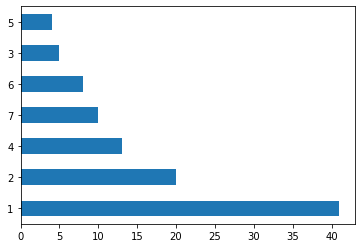

In [166]:
df2['class_type'].value_counts().plot.barh()

**4. Выполните масштабирование количественных признаков**

In [167]:
df2['class_type'] = df2['class_type'].apply(lambda x: str(x))
quantitative = [column for column in df2.columns if df2[column].dtype.name != 'object']
print(f"Количественые признаки: {quantitative}")
categorial = [column for column in df2.columns if df2[column].dtype.name == 'object']
print(f"Категориальные признаки: {categorial}")

Количественые признаки: ['hair', 'feathers', 'eggs', 'milk', 'airborne', 'aquatic', 'predator', 'toothed', 'backbone', 'breathes', 'venomous', 'fins', 'legs', 'tail', 'domestic', 'catsize']
Категориальные признаки: ['class_type']


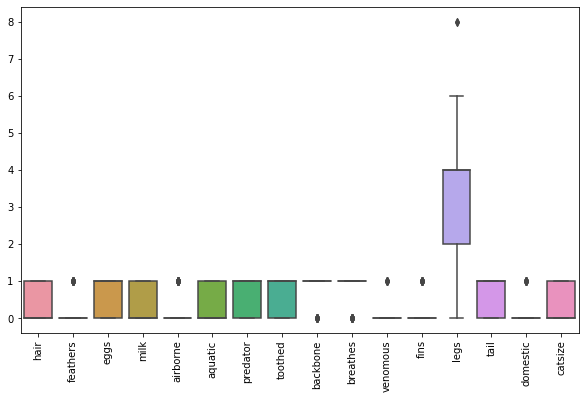

In [168]:
pt.figure(figsize=(10,6))
pt.xticks(rotation=90)
sn.boxplot(data=df2[quantitative])
pt.show()

In [169]:
quantitative = [column for column in df2.columns if df2[column].dtype.name != 'object']
print(f"Количественые признаки: {quantitative}")
categorial = [column for column in df2.columns if df2[column].dtype.name == 'object']
print(f"Категориальные признаки: {categorial}")

Количественые признаки: ['hair', 'feathers', 'eggs', 'milk', 'airborne', 'aquatic', 'predator', 'toothed', 'backbone', 'breathes', 'venomous', 'fins', 'legs', 'tail', 'domestic', 'catsize']
Категориальные признаки: ['class_type']


In [170]:
scaler = MinMaxScaler()
df2[quantitative] = scaler.fit_transform(df2[quantitative])
df2.head()

,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type
0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.5,0.0,0.0,1.0,1
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.5,1.0,0.0,1.0,1
2,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,4
3,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.5,0.0,0.0,1.0,1
4,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.5,1.0,0.0,1.0,1


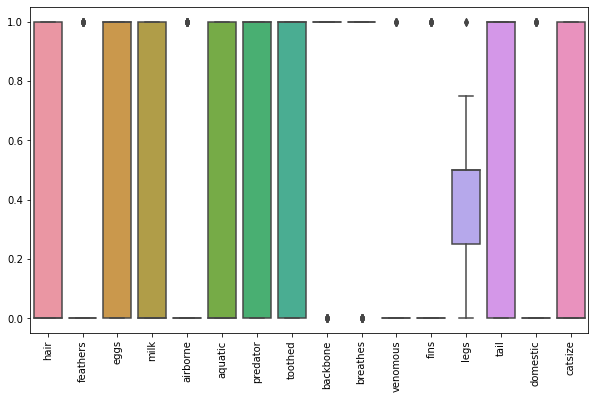

In [171]:
pt.figure(figsize=(10,6))
pt.xticks(rotation=90)
sn.boxplot(data=df2[quantitative])
pt.show()

**5. Замена категориальных признаков**

In [172]:
quantitative = [column for column in df2.columns if df2[column].dtype.name != 'object']
print(f"Количественые признаки: {quantitative}")
categorial = [column for column in df2.columns if df2[column].dtype.name == 'object']
print(f"Категориальные признаки: {categorial}")

Количественые признаки: ['hair', 'feathers', 'eggs', 'milk', 'airborne', 'aquatic', 'predator', 'toothed', 'backbone', 'breathes', 'venomous', 'fins', 'legs', 'tail', 'domestic', 'catsize']
Категориальные признаки: ['class_type']


In [173]:
binary = [i for i in categorial if len(df2[i].unique()) == 2]
nonbinary = [i for i in categorial if len(df2[i].unique()) > 2]

for col in binary:
    for i, unic_item in enumerate(df[col].unique()):
        df[col] = df[col].replace(to_replace=[unic_item], value=[i])
        
df_nonbinary = pd.get_dummies(df2[nonbinary])
df2.drop(nonbinary, axis=1, inplace=True)
df2 = pd.concat([df_nonbinary, df2], axis=1)
        
df2.head()

,class_type_1,class_type_2,class_type_3,class_type_4,class_type_5,class_type_6,class_type_7,hair,feathers,eggs,...,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize
0,1,0,0,0,0,0,0,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.5,0.0,0.0,1.0
1,1,0,0,0,0,0,0,1.0,0.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.5,1.0,0.0,1.0
2,0,0,0,1,0,0,0,0.0,0.0,1.0,...,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,1,0,0,0,0,0,0,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.5,0.0,0.0,1.0
4,1,0,0,0,0,0,0,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.5,1.0,0.0,1.0


**6. Оцените корреляцию между признаков и удалите те признаки, которые коррелируют с наибольшим числом других**

              class_type_1  class_type_2  class_type_3  class_type_4  \
class_type_1      1.000000     -0.410761     -0.188654     -0.317722   
class_type_2     -0.410761      1.000000     -0.113402     -0.190987   
class_type_3     -0.188654     -0.113402      1.000000     -0.087716   
class_type_4     -0.317722     -0.190987     -0.087716      1.000000   
class_type_5     -0.167865     -0.100906     -0.046344     -0.078050   
class_type_6     -0.242449     -0.145739     -0.066935     -0.112729   
class_type_7     -0.274028     -0.164722     -0.075653     -0.127412   
hair              0.878503     -0.427851     -0.196503     -0.330941   
feathers         -0.410761      1.000000     -0.113402     -0.190987   
eggs             -0.938848      0.419248      0.099944      0.324287   
milk              1.000000     -0.410761     -0.188654     -0.317722   
airborne         -0.366765      0.656553     -0.127412     -0.214581   
aquatic          -0.362613     -0.058552     -0.074542      0.51

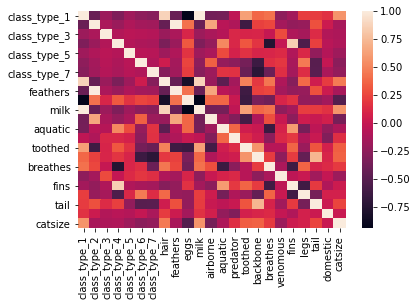

In [174]:
corr_matrix = df2.corr()
sn.heatmap(corr_matrix);
print(corr_matrix)

**7.Заполните пропущенные значения в данных**

In [175]:
df2.isnull().sum()

class_type_1    0
class_type_2    0
class_type_3    0
class_type_4    0
class_type_5    0
class_type_6    0
class_type_7    0
hair            0
feathers        0
eggs            0
milk            0
airborne        0
aquatic         0
predator        0
toothed         0
backbone        0
breathes        0
venomous        0
fins            0
legs            0
tail            0
domestic        0
catsize         0
dtype: int64

Пропущенных значений нет

**8.Решите поставленную задачу классификации в соответствии с заданием**

In [176]:
X, y = df2.drop('class_type_1', axis=1), df2['class_type_1']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

In [177]:
# K ближайших соседей
knn = KNeighborsClassifier()
params = {'n_neighbors': list(range(1, 50))}
knn_grid = GridSearchCV(knn, params)
knn_grid.fit(X_train, y_train)
best_num = knn_grid.best_estimator_.n_neighbors
best_score = knn_grid.best_score_

print('best train score: ', best_score,
      '\t at neighbors number: ', best_num)

rnc = KNeighborsClassifier(n_neighbors=best_num)
rnc.fit(X_train, y_train)
best_score  = np.mean(y_test  == rnc.predict(X_test))
print('test score: ', best_score)

best train score:  1.0 	 at neighbors number:  1
test score:  1.0


In [178]:
# бинарное решающее дерево
dtc = DecisionTreeClassifier()
params = {'max_depth': list(range(1,12)), 'max_features': list(range(1,12))}
dtc_grid = GridSearchCV(dtc, params)
dtc_grid.fit (X_train, y_train)
best_features = dtc_grid.best_estimator_.max_features
best_depth = dtc_grid.best_estimator_.max_depth
best_score = dtc_grid.best_score_
print('best train score:', best_score, 
      '\t at features number:', best_features,
      '\t at depth:', best_depth)

dtc = DecisionTreeClassifier(max_depth=best_depth, max_features=best_features)
dtc.fit(X_train, y_train)
best_score  = np.mean(y_test == dtc.predict(X_test))
print('test score: ', best_score)

best train score: 1.0 	 at features number: 6 	 at depth: 3
test score:  0.9354838709677419


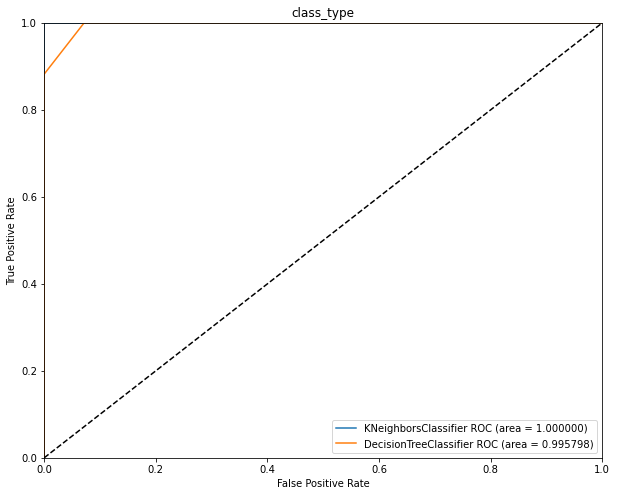

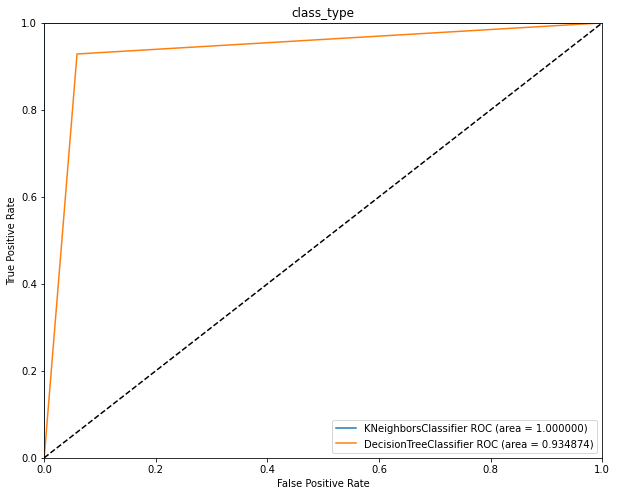

In [179]:
pt.figure(figsize=(10,8))
# K соседей
knn = KNeighborsClassifier ( n_neighbors =best_num)
probas_knn0 = knn.fit(X_train, y_train).predict_proba (X_test)
tpr, fpr, thresholds = roc_curve(y_test, probas_knn0[:,0])
roc_auc  = auc(fpr, tpr)
pt.plot(fpr, tpr, label='%s ROC (area = %f)' % ('KNeighborsClassifier', roc_auc)) 
# бинарное решающее дерево
dtc = DecisionTreeClassifier(max_depth=best_depth, max_features=best_features)
probas_dtc0 = dtc.fit(X_train, y_train).predict_proba (X_test)
tpr, fpr, thresholds = roc_curve(y_test, probas_dtc0[:,0])
roc_auc  = auc (fpr, tpr)
pt.plot(fpr, tpr, label='%s ROC (area = %f)' % ('DecisionTreeClassifier', roc_auc))   

# вывод графика
pt.plot([0, 1], [0, 1], 'k--')
pt.xlim([0.0, 1.0])
pt.ylim([0.0, 1.0])
pt.xlabel('False Positive Rate')
pt.ylabel('True Positive Rate')
pt.legend(loc=4, fontsize='medium')
pt.title('class_type')
pt.show()


pt.figure(figsize=(10,8))
# K соседей
knn = KNeighborsClassifier( n_neighbors = best_num)
probas_knn1 = knn.fit(X_train, y_train).predict_proba (X_test)
fpr, tpr, thresholds = roc_curve(y_test, probas_knn1[:,1])
roc_auc  = auc(fpr, tpr)
pt.plot(fpr, tpr, label='%s ROC (area = %f)' % ('KNeighborsClassifier', roc_auc)) 
# бинарное решающее дерево
dtc = DecisionTreeClassifier(max_depth=best_depth, max_features=best_features)
probas_dtc1 = dtc.fit(X_train, y_train).predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, probas_dtc1[:,1])
roc_auc  = auc(fpr, tpr)
pt.plot(fpr, tpr, label='%s ROC (area = %f)' % ('DecisionTreeClassifier', roc_auc))   
# вывод графика
pt.plot([0, 1], [0, 1], 'k--')
pt.xlim([0.0, 1.0])
pt.ylim([0.0, 1.0])
pt.xlabel('False Positive Rate')
pt.ylabel('True Positive Rate')
pt.legend(loc=4, fontsize='medium')
pt.title('class_type')
pt.show()

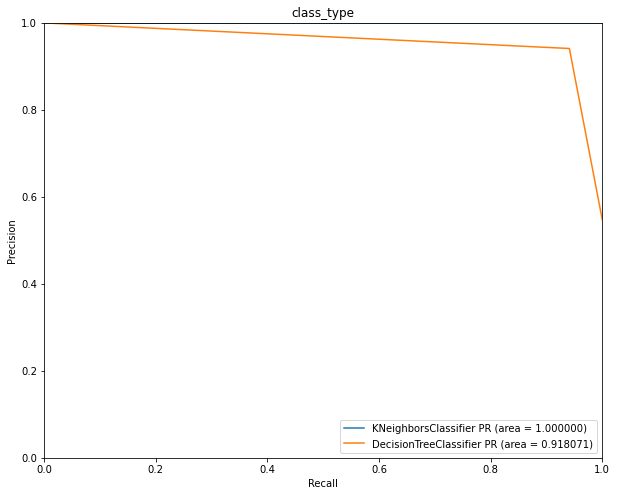

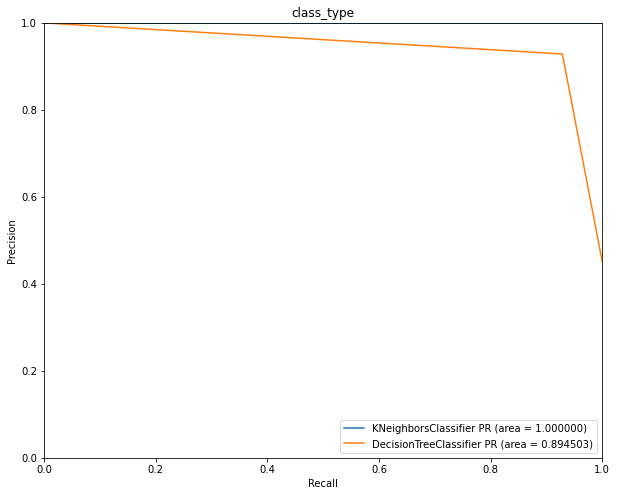

In [180]:
pt.figure(figsize=(10,8))
y_test_invers = []
for i, y in enumerate(y_test.reset_index(drop=True)):
    y_test_invers.append(1-y)
# K соседей
precision, recall, thresholds = precision_recall_curve(y_test_invers, probas_knn1[:,0])
aps_knn1 = average_precision_score(y_test_invers,probas_knn1[:,0])
pt.plot(recall, precision, label='%s PR (area = %f)' % ('KNeighborsClassifier', aps_knn1)) 
# бинарное решающее дерево
precision, recall, thresholds = precision_recall_curve(y_test_invers, probas_dtc1[:,0])
aps_dtc1 = average_precision_score(y_test_invers,probas_dtc1[:,0])
pt.plot(recall, precision, label='%s PR (area = %f)' % ('DecisionTreeClassifier',  aps_dtc1)) 
# вывод графика
pt.xlabel('Recall')
pt.ylabel('Precision')
pt.xlim([0.0, 1.0])
pt.ylim([0.0, 1.0])
pt.legend(loc=4, fontsize='medium')
pt.title('class_type')
pt.show()


pt.figure(figsize=(10,8))
# K соседей
precision, recall, thresholds = precision_recall_curve(y_test, probas_knn0[:,1])
aps_knn0 = average_precision_score(y_test,probas_knn0[:,1])
pt.plot(recall, precision, label='%s PR (area = %f)' % ('KNeighborsClassifier', aps_knn0)) 
# бинарное решающее дерево
precision, recall, thresholds = precision_recall_curve(y_test, probas_dtc1[:,1])
aps_dtc1 = average_precision_score(y_test,probas_dtc1[:,1])
pt.plot(recall, precision, label='%s PR (area = %f)' % ('DecisionTreeClassifier',  aps_dtc1)) 
# вывод графика
pt.xlabel('Recall')
pt.ylabel('Precision')
pt.xlim([0.0, 1.0])
pt.ylim([0.0, 1.0])
pt.legend(loc=4, fontsize='medium')
pt.title('class_type')
pt.show()

**9. Сравните кривые для классификаторов, указанных в задании, сделайте выводы.**

Классификаторы k ближайших соседей(по количеству ближайших объектов) и бинарное решающее дерево имеют приблизительно одинаковые показатели качества относительно PR и ROC кривых.